In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
import os
import yaml
import pickle
from datetime import datetime

In [3]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [4]:
from grid.policy import get_state, next_state, get_cell_i, get_cell_j
from grid.policy import get_policy, get_ratio, sample_policy, policy_noising, support, policy_data
from grid.policy import occupation_measure, occupation_measure_sanity
from grid.utils import sample_standard_simplex, generate_id
from grid.params import transition_probability_matrix, discounted_probability_matrix, expected_reward_vector, expected_risk_vector
from grid.optimize import optimal_policy
from grid.plotting import plot_policy, plot_occupation_measure, plot_reward, plot_ratio

In [5]:
configs_file = '../configs.yaml'

with open(configs_file,'r') as handle:
    try:
        configs = yaml.safe_load(handle)
    except yaml.YAMLError as e:
        print('ERROR ... Could not load configs yaml. Run the command `jupyter notebook` using `notebooks` as your PWD')
        raise e

# Notebook Sections

* * *

(1) Grid world.<br>
(2) Hyper-parameters.<br>
(3) Transition probabilities.<br>
(4) Reward.<br>
(5) Risk.<br>
(6) Sample policy.<br>
(7) Optimal policy.<br>
(8) Policy noising.<br>
(9) Policy data.<br>

* * *

## Grid World

* * *

Consider an $m \times n$ grid. Each tile of the grid constitutes a state. 

$$ \begin{array}{|c|c|c|}
\hline (0,0) & \cdots & (0,n-1) \\ \hline
\hline &  &  \\ \hline 
\hline (m-1,0) & \cdots & (m-1,n-1) \\
\hline
\end{array} $$

Actions are $\mathcal{A} = \{U,D,L,R,N\}$ correspond to moving *up*, *down*, *left*, *right*, or *none* for staying put. 

When possible, we move with probability $1-\delta$ under action $a=U,D,L,R$. There is a small transition probability $\delta$ to one of the other states.

The goal is to reach a pre-determined terminal cell.

* * *

## Hyper-parameters

* <u>User-defined hyper-params</u>: grid dimensions, $\delta$, discount, number of obstacles, time horizon, etc.
* <u>Fixed</u>: derived hyper-params.
* <u>Sampled hyper-params</u>: allow variability in the grid-world problem w.r.t. the obstacles, initial state distribution, initial state.

### * User-defined

Grid dimensions.

In [6]:
m, n = 5, 5

Probability for random state under actions U / D / L / R.

In [7]:
delta = 0.05

Discount factor.

In [8]:
discount = 0.95

Number of obstacles in grid.

In [9]:
obstacle_num = 3

Noise added to optimal policy to generate data. Noise level in $[0,1]$, with $1$ giving rise to a completely random (non-deterministic) policy.

In [10]:
noise = 0.05

Noise added to expected reward / risk vectors.

In [11]:
epsilon = 0.01

Tolerance for near-zero results.

In [12]:
tol = 1e-6

### * Fixed

In [13]:
actions = ['U','D','L','R','N']

In [14]:
states = [*range(m*n)]

In [15]:
state_num = len(states)
action_num = len(actions)

In [16]:
atol = abs(int(np.log10(tol)))-2

### * User-defined

Terminal cell.

In [17]:
final = get_state(m-1,n-1,m,n)

Time horizon: number of data points in policy dataset.

In [18]:
T = 10*action_num*(state_num)**2

Initial cell.

In [19]:
init_state = [0,0]

In [20]:
init_state_index = get_state(init_state[0],init_state[1],m,n)
state_dist = np.eye(N=1,M=m*n,k=init_state_index).flatten() # atomic measure at init state

### * Sampled

Sampled obstacle cells.

In [21]:
states_excluded = list(set(states) - set([final,init_state_index]))
obstacles = []
while len(states_excluded)>0:
    obstacle = next_state(states_excluded)[0]
    states_excluded = list(set(states_excluded)-set([obstacle]))
    obstacles.append(obstacle)
    if len(obstacles)==obstacle_num:
        break        

In [22]:
obstacles

[4, 15, 11]

## Transition Probabilities

For $a \in \mathcal{A}$, the transition matrix $P(a) \in {M}_{\vert \mathcal{S} \vert \times \lvert \mathcal{S} \rvert}(\mathbb{R})$ is defined as
$$\begin{align*}
    & P(a)_{s',s} = \Pr[s' \vert s,a]
\end{align*}$$

i.e., the probability of transitioning from state $s$ to state $s'$ under action $a$. 

In [23]:
P = transition_probability_matrix(m,n,delta,tol=tol)

## Reward

Consider $c \in \mathbb{R}^{\vert S \vert}$ and define the expected reward vector $r \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ to be

$$\begin{align*}
    & r(s,a) = \sum_{s' \in \mathcal{S}} c_{s'} P(a)_{s',s} 
\end{align*}$$

Pick some grid state $s_f$ as the final destination. Let $c_{s_f} = 0$ and $c_{s} = -1$ for $s \neq s_f$. Maximizing the reward would then imply reaching the destination by the shortest route. 

We can add a set of obstacles $\mathcal{S}_O \subseteq \mathcal{S}$ to the grid by setting $c_s = M \ll -1$ for $s \in \mathcal{S}_O$.

In __[Chow et al, NIPS '15](https://proceedings.neurips.cc/paper/2015/hash/64223ccf70bbb65a3a4aceac37e21016-Abstract.html)__ one has $M = {2}/{(1-\gamma)}$ for the discount factor $\gamma$.


We will add some jitter to the reward vector to ensure non-degeneracy.

In [24]:
r = -expected_reward_vector(m,n,discount,final,obstacles,P,epsilon=epsilon)

## Risk

We'll define a risk vector $d \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ weighed against moving along the upper or lower edges of the grid (this will ensure no cell is degenerate).

We will also add a bit of additional risk for either doing nothing or walking into the boundary.

There is a non-zero lower bound on risk to avoid "exploding" ratio for epsilon risks.

We will add some jitter to the reward vector to ensure non-degeneracy.

In [25]:
d = -expected_risk_vector(m,n,epsilon=epsilon)

## Sample Policy

A policy $\pi: \mathcal{S} \rightarrow \Delta_{\mathcal{A}}$ is a map from states to distributions over $\mathcal{A}$.

In [26]:
p = sample_policy(states,actions,is_deterministic=False,beta=0.1) # beta factor to downweight 'do nothing'

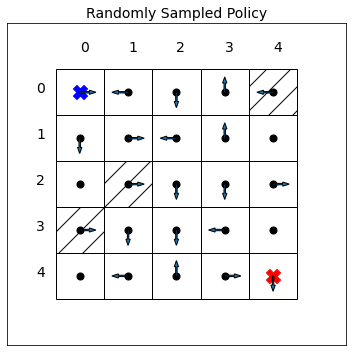

In [27]:
title = 'Randomly Sampled Policy'
plot_policy(p,states,actions,m,n,init_state_index,final,obstacles=obstacles,cell_unit_length=1.0,title=title)

## Optimal Policy

The optimal policy for EMRDP (with $\omega = 1$), phrased in terms of the occupancy measure $\rho^\pi \in \mathbb{R}^{\vert S \vert \times \vert \mathcal{A} \vert}$ of $\pi$, is formulated for this problem as

$$\min_{\pi} \bigg\{ \frac{r^T \rho^\pi}{d^T \rho^\pi} \,\bigg| \, Q\rho^\pi=\mu, \rho^\pi \geq 0 \bigg\} $$

In the discounted model, 
$$\begin{align*}
    Q = \bigg[ I-\gamma P(a_1) \, \bigg| \,\cdots\, \bigg|\, I - \gamma P(a_k) \bigg] , \quad
\end{align*}$$

for $\mathcal{A} = \{a_1,\ldots,a_k\}$, some initial state distribution $\mu$, and discount factor $\gamma$.

In [28]:
Q = discounted_probability_matrix(m,n,discount,delta,tol=tol)

The row vector $(1,\ldots,1) \in \mathbb{R}^{\vert \mathcal{S} \vert}$ is an eigenvector of $Q$ for the  eigenvalue $(1-\gamma)$.

In [29]:
np.ones((1,Q.shape[0])) @ Q / (1-discount)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

Algorithm for finding the true optimal policy. Issues may arise due to numerical instabilities.

In [30]:
rhos, rewards, risks, success = optimal_policy(states,actions,Q,r,d,state_dist,discount,tol=tol,is_verbose=False)

In [31]:
print('Policy optimization successful: {}'.format(success))

Policy optimization successful: True


In [32]:
# sanity check: all rhos are occupation measures

A = np.vstack([Q,d.T])

for rho in rhos:
    occupation_measure_sanity(rho,A,state_dist,discount,tol=tol*100)

Plot algorithm results for finding the true optimal policy.

In [33]:
argmin=0

for i, (re, ri) in enumerate(zip(rewards, risks)):
    print('Iteration {}: reward {:.3f}, risk {:.3f}, ratio: {:.3f}'.format(i,(re),ri,(re)/(ri)))
    argmin = i if (re)/(ri) < rewards[argmin]/risks[argmin] else argmin

Iteration 0: reward -2.865, risk -10.009, ratio: 0.286
Iteration 1: reward -1.364, risk -10.009, ratio: 0.136
Iteration 2: reward -1.225, risk -10.009, ratio: 0.122
Iteration 3: reward -1.157, risk -10.009, ratio: 0.116
Iteration 4: reward -1.030, risk -10.008, ratio: 0.103
Iteration 5: reward -1.027, risk -10.008, ratio: 0.103
Iteration 6: reward -0.954, risk -9.991, ratio: 0.096
Iteration 7: reward -0.954, risk -9.991, ratio: 0.095
Iteration 8: reward -0.954, risk -9.991, ratio: 0.095
Iteration 9: reward -0.952, risk -9.989, ratio: 0.095
Iteration 10: reward -0.952, risk -9.988, ratio: 0.095
Iteration 11: reward -0.950, risk -9.971, ratio: 0.095
Iteration 12: reward -0.672, risk -7.251, ratio: 0.093
Iteration 13: reward -0.669, risk -7.201, ratio: 0.093
Iteration 14: reward -0.663, risk -7.083, ratio: 0.094
Iteration 15: reward -0.663, risk -6.976, ratio: 0.095
Iteration 16: reward -0.663, risk -6.931, ratio: 0.096
Iteration 17: reward -0.663, risk -6.904, ratio: 0.096
Iteration 18: 

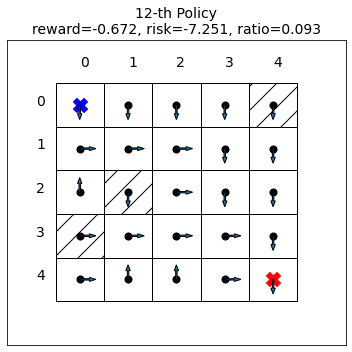

In [34]:
i = argmin

p = get_policy(np.around(rhos[i],atol), states, actions)
title = '{}-th Policy\nreward={:.3f}, risk={:.3f}, ratio={:.3f}'.format(i,rewards[i],risks[i],rewards[i]/risks[i])

plot_policy(p,states,actions,m,n,init_state_index,final,obstacles=obstacles,cell_unit_length=1.0,title=title)

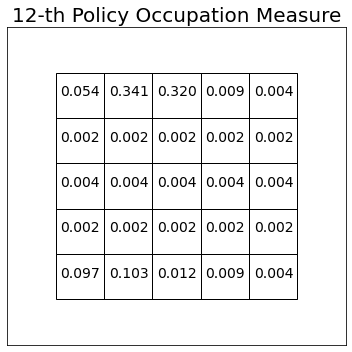

In [35]:
title = '{}-th Policy Occupation Measure'.format(i)
plot_occupation_measure(rhos[-1],states,actions,m,n,tol=tol*100,cell_unit_length=1.0,title=title)

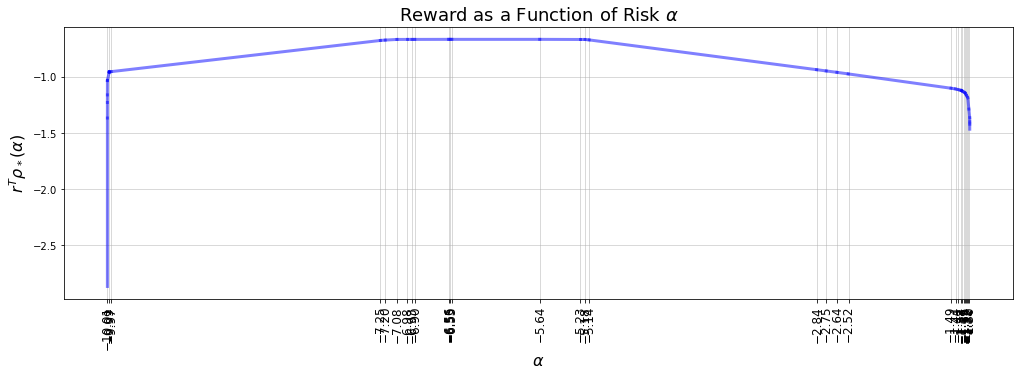

In [36]:
plot_reward(risks, rewards, atol=2, figsize=(17,5))

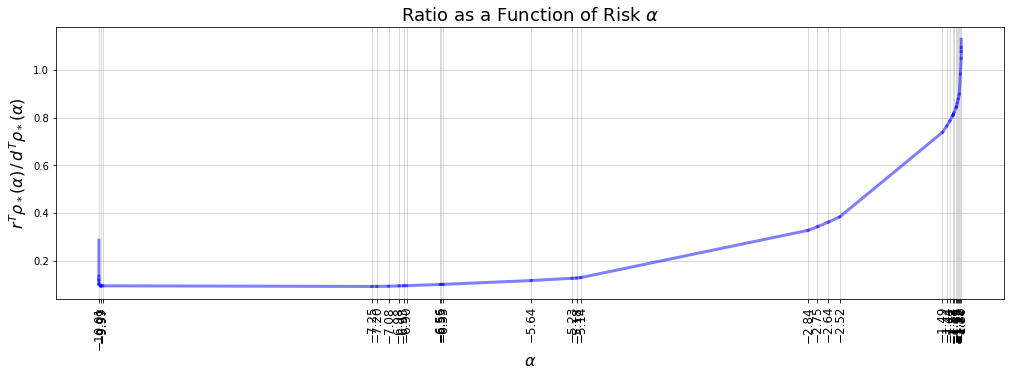

In [37]:
plot_ratio(risks, rewards, atol=2, figsize=(17,5))

## Policy Noising

Add noise to the optimal policy.

In [38]:
p_opt = get_policy(np.around(rhos[-1],atol), states, actions)

In [39]:
p_data = policy_noising(p_opt, noise, states, actions, state_dist, discount, P)

## Policy Data

Generate tabular data from the noised optimal policy.

Policy data, as well as all other data necessary for reproducibility, will be pickled.

In [40]:
policy_data_id = generate_id()
now = datetime.now().strftime('%Y-%m-%d-%H%M')

In [41]:
df = policy_data(p_data,init_state_index,T,states,actions,m,n,P,r,d)

In [42]:
data = {
    'm': m,
    'n': n,
    'final': final,
    'obstacles': obstacles,
    'init_state': init_state,
    'state_dist': state_dist,
    'discount': discount,
    'delta': delta,
    'tol': tol,
    'noise': noise,
    'epsilon': epsilon,
    'P': P,
    'r': r,
    'd': d,
    'p_data': p_data,
    'p_opt': p_opt,
    'pareto_rewards': rewards,
    'pareto_risks': risks,
    'pareto_rhos': rhos,
    'df': df,
    'policy_data_id': policy_data_id,
    'timestamp': now
}

Directory to store generated data pickle.

In [43]:
root = configs['local']['buckets']['data']

Write to local storage?

In [44]:
is_write = False # True to write data to local storage

In [45]:
p_file = 'grid_world_data_{}.pickle'.format(policy_data_id)
p_path = os.path.join(root,p_file)

if is_write:
    
    with open(p_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(p_path, 'rb') as handle:
        data = pickle.load(handle)

    data['df'].head()

## Recalculate

Recalculate the optimal policy without eliminating indices.

In [46]:
from grid.utils import load_data

First test case.

In [76]:
file_new = 'grid_world_recaculate_policyID_0aeld9z3_to_dataID=j2bv6ue1_m=5_n=5_noise=10.pickle'
file_old = 'grid_world_experimentID=ijcai_dataID=0aeld9z3_m=5_n=5_noise=10.pickle'

In [77]:
data_new = load_data(file_new,root=configs['local']['buckets']['data'])
data_old = load_data(file_old,root=configs['local']['buckets']['data_dest'])

In [78]:
p_opt_new = data_new['p_opt']
p_opt_old = data_old['p_opt']
risks_new = data_new['pareto_risks']
rewards_new = data_new['pareto_rewards']
risks_old = data_old['pareto_risks']
rewards_old = data_old['pareto_rewards']

In [79]:
obstacles_new = data_new['obstacles']
obstacles_old = data_old['obstacles']

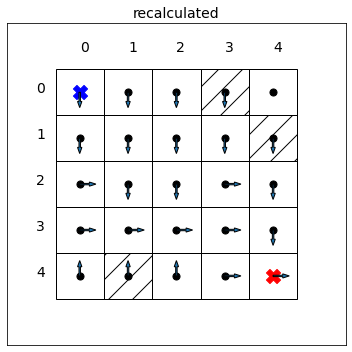

In [80]:
title = 'recalculated'
plot_policy(p_opt_new,states,actions,m,n,init_state_index,final,obstacles=obstacles_new,cell_unit_length=1.0,title=title)

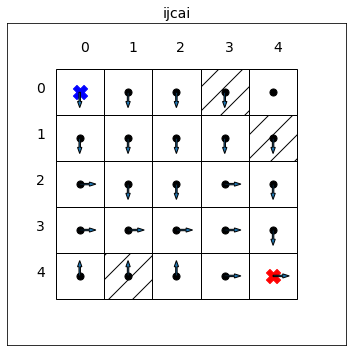

In [81]:
title = 'ijcai'
plot_policy(p_opt_old,states,actions,m,n,init_state_index,final,obstacles=obstacles_old,cell_unit_length=1.0,title=title)

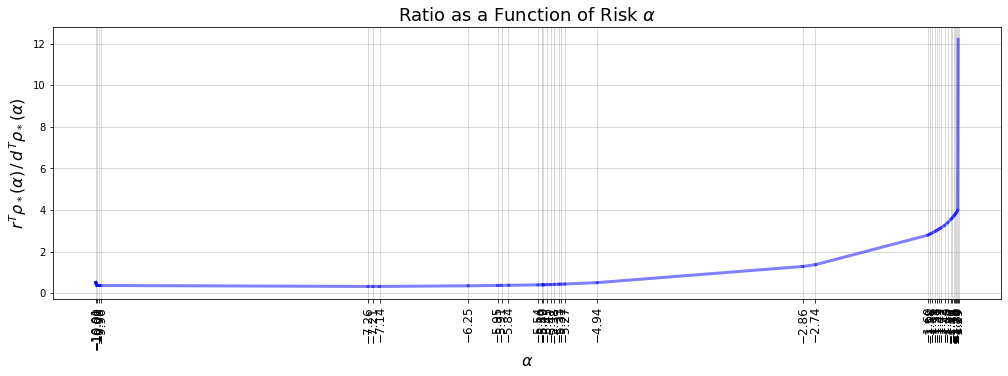

In [82]:
N = None # len(risks_old)
plot_ratio(risks_new[:N], rewards_new[:N], atol=2, figsize=(17,5))

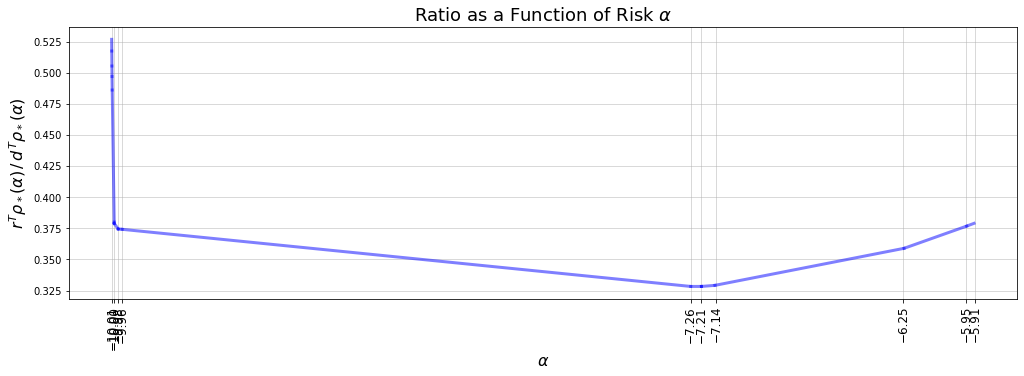

In [62]:
plot_ratio(risks_old, rewards_old, atol=2, figsize=(17,5))

Second test case.

In [91]:
file_new = 'grid_world_recaculate_policyID_00d17m9g_to_dataID=s1fvbfhs_m=5_n=5_noise=30.pickle'
file_old = 'grid_world_experimentID=ijcai_dataID=00d17m9g_m=5_n=5_noise=30.pickle'

In [92]:
data_new = load_data(file_new,root=configs['local']['buckets']['data'])
data_old = load_data(file_old,root=configs['local']['buckets']['data_dest'])

In [93]:
p_opt_new = data_new['p_opt']
p_opt_old = data_old['p_opt']
risks_new = data_new['pareto_risks']
rewards_new = data_new['pareto_rewards']
risks_old = data_old['pareto_risks']
rewards_old = data_old['pareto_rewards']

In [94]:
obstacles_new = data_new['obstacles']
obstacles_old = data_old['obstacles']

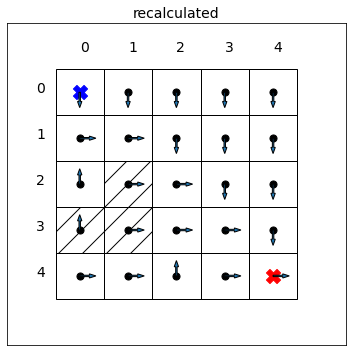

In [95]:
title = 'recalculated'
plot_policy(p_opt_new,states,actions,m,n,init_state_index,final,obstacles=obstacles_new,cell_unit_length=1.0,title=title)

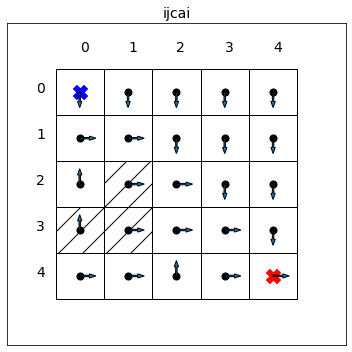

In [96]:
title = 'ijcai'
plot_policy(p_opt_old,states,actions,m,n,init_state_index,final,obstacles=obstacles_old,cell_unit_length=1.0,title=title)

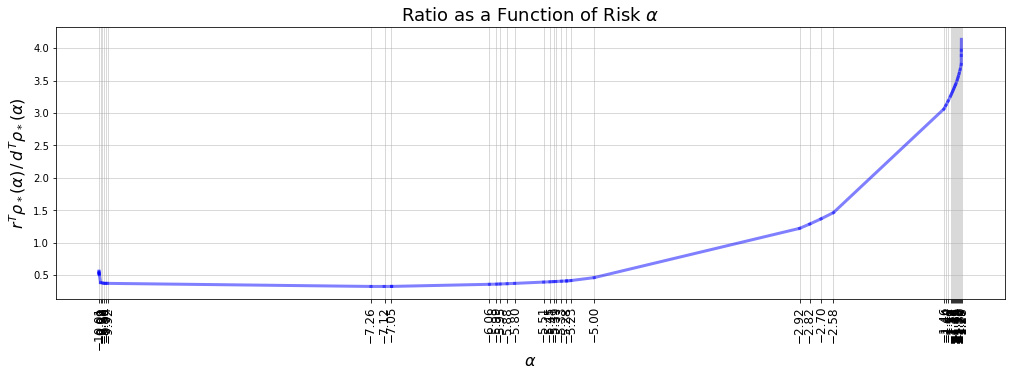

In [99]:
N = None# len(risks_old)
plot_ratio(risks_new[:N], rewards_new[:N], atol=2, figsize=(17,5))

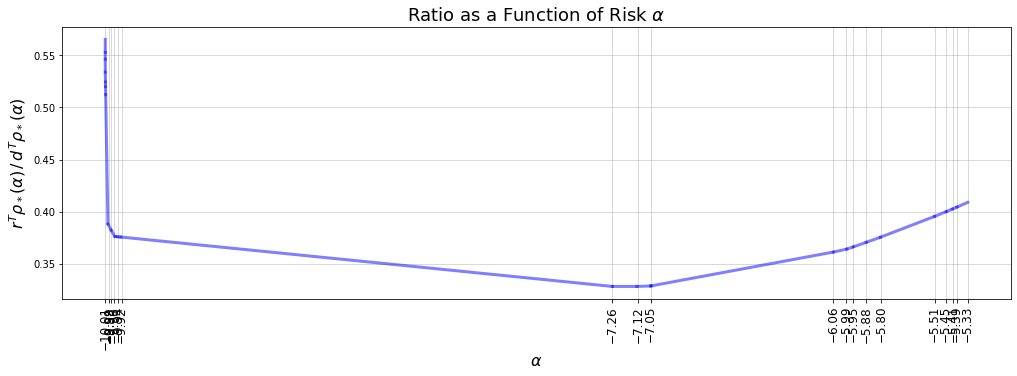

In [98]:
plot_ratio(risks_old, rewards_old, atol=2, figsize=(17,5))

All paper experiments.

In [108]:
from grid.utils import load_all

datas_new = load_all(root_in=configs['local']['buckets']['data'])
datas_old = load_all(root_in=configs['local']['buckets']['data_dest'])

In [109]:
data_pairs = []

for data_new in datas_new:
    
    idx = data_new['recalc_policy_data_id']
    
    for data_old in datas_old:
        
        if idx == data_old['policy_data_id']:
            
            data_pairs.append({idx: {'old': data_old, 'new': data_new}})
            
            continue

In [118]:
idxs = [list(pair.keys())[0] for pair in data_pairs]

In [120]:
for data_old in datas_old:
    
    idx = data_old['policy_data_id']
    
    if idx in idxs:
        continue
    else:
        print('Failed to reclaculate for data ID:',idx)

Failed to reclaculate for data ID: 8ired11d


In [136]:
not_identical_idxs = []

for pair in data_pairs:
    
    idx = list(pair.keys())[0]    
    data_new = pair[idx]['new']
    data_old = pair[idx]['old']
    
    p_opt_new = data_new['p_opt']
    p_opt_old = data_old['p_opt']

    p_opt_old_arr = np.concatenate([arr[None,:] for arr in list(p_opt_old.values())])
    p_opt_old_arr = np.concatenate([arr[None,:] for arr in list(p_opt_new.values())])
    
    if np.sum(p_opt_old_arr-p_opt_old_arr)!=0.0:
        not_identical_idxs.append(idx)

In [137]:
not_identical_idxs

[]

In [138]:
pareto_lengths = []

for data_new in datas_new:
    
    rewards = data_new['pareto_rewards']
    risks = data_new['pareto_risks']
    
    if len(rewards)==len(risks):
        pareto_lengths.append(len(risks))
    

In [149]:
steps_to_optimal = []

for data_new in datas_new:
    
    rewards = data_new['pareto_rewards']
    risks = data_new['pareto_risks']
    
    if len(rewards)==len(risks):
        
        argmin=0
        for i, (re, ri) in enumerate(zip(rewards, risks)):
            argmin = i if (re)/(ri) < rewards[argmin]/risks[argmin] else argmin
            
        steps_to_optimal.append(argmin+1)
    

In [150]:
print('Number of Pareto lengths:',len(pareto_lengths))
print('Number of Steps to Optimal Data Points:',len(steps_to_optimal))

Number of Pareto lengths: 599
Number of Steps to Optimal Data Points: 599


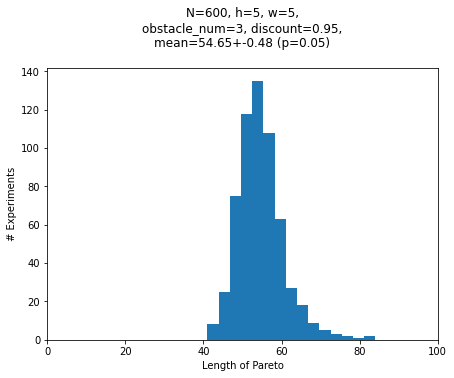

In [170]:
import matplotlib.pyplot as plt
import scipy.stats as st

bins = 15
pval = 0.05
samples = np.array(pareto_lengths)
    
plt.figure(figsize=(7,5))

ci = st.norm.interval(alpha=1-pval,loc=np.mean(samples),scale=st.sem(samples))
average = samples.mean()

title = 'N={}, h={}, w={},\nobstacle_num={}, discount={},\nmean={:.2f}+-{:.2f} (p={})\n'.format(
    len(steps_to_optimal)+1,
    m,n,obstacle_num,discount,
    average,(ci[1]-ci[0])/2,pval
)

plt.hist(samples,bins=bins)
plt.xlim(0,100)
plt.title(title)
plt.xlabel('Length of Pareto')
plt.ylabel('# Experiments');

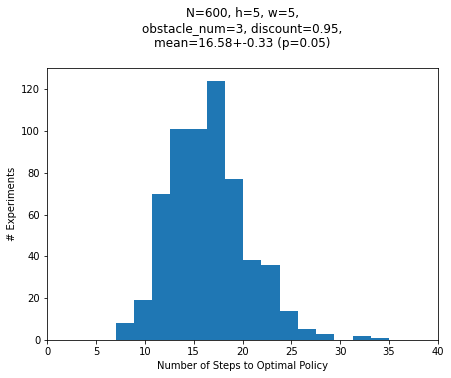

In [172]:
import matplotlib.pyplot as plt
import scipy.stats as st

bins = 15
pval = 0.05
samples = np.array(steps_to_optimal)
    
plt.figure(figsize=(7,5))

ci = st.norm.interval(alpha=1-pval,loc=np.mean(samples),scale=st.sem(samples))
average = samples.mean()

title = 'N={}, h={}, w={},\nobstacle_num={}, discount={},\nmean={:.2f}+-{:.2f} (p={})\n'.format(
    len(steps_to_optimal)+1,
    m,n,obstacle_num,discount,
    average,(ci[1]-ci[0])/2,pval
)

plt.hist(samples,bins=bins)
plt.xlim(0,40)
plt.title(title)
plt.xlabel('Number of Steps to Optimal Policy')
plt.ylabel('# Experiments');